<a href="https://colab.research.google.com/github/Ritesh24f1001677/Net_Zero-Maturity-Model-IIT-BHU-INTERNSHIP/blob/main/NZE_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
import numpy as np
import pandas as pd

np.random.seed(42)
N = 10000

# =================================================
# 1. BASIC MSME ATTRIBUTES
# =================================================
firm_size = np.random.choice(
    ["micro", "small", "medium"],
    N,
    p=[0.45, 0.35, 0.20]
)

industry = np.random.choice(
    ["textile", "food", "chemical", "metal", "plastic"],
    N
)

size_efficiency = {
    "micro": 0.85,
    "small": 1.00,
    "medium": 1.20
}

size_cost_penalty = {
    "micro": 1.15,
    "small": 1.00,
    "medium": 0.90
}

industry_emission_factor = {
    "textile": 1.0,
    "food": 0.9,
    "plastic": 1.1,
    "metal": 1.6,
    "chemical": 1.9
}

size_eff = np.array([size_efficiency[s] for s in firm_size])
size_cost = np.array([size_cost_penalty[s] for s in firm_size])
ind_em = np.array([industry_emission_factor[i] for i in industry])

# =================================================
# 2. OPERATIONAL COSTS
# =================================================
OS = np.random.normal(55, 10, N) * size_cost
OM = np.random.normal(80, 15, N) * size_cost
OD = np.random.normal(45, 8, N) * size_cost

# =================================================
# 3. FIXED EMISSIONS
# =================================================
OE_supplier = np.random.uniform(20, 45, N) * ind_em
OE_manufacturer = np.random.uniform(50, 120, N) * ind_em
OE_distributor = np.random.uniform(15, 40, N) * ind_em

# =================================================
# 4. TRANSPORT (STRONGLY DIFFERENTIATED)
# =================================================
transport_tech = np.random.choice(
    ["diesel", "EV"],
    N,
    p=[0.65, 0.35]
)

distance = np.random.uniform(50, 600, N)

# Base transport costs
C_ij = np.where(
    transport_tech == "diesel",
    0.018 * distance * np.random.uniform(0.9, 1.1, N),
    0.030 * distance * np.random.uniform(1.1, 1.5, N)
)

C_jk = np.where(
    transport_tech == "diesel",
    0.022 * distance * np.random.uniform(0.9, 1.2, N),
    0.035 * distance * np.random.uniform(1.1, 1.6, N)
)

# Transport emissions
TE_ij = np.where(
    transport_tech == "diesel",
    np.random.uniform(0.8, 1.2, N),
    np.random.uniform(0.10, 0.25, N)
)

TE_jk = np.where(
    transport_tech == "diesel",
    np.random.uniform(0.9, 1.4, N),
    np.random.uniform(0.12, 0.30, N)
)

# EV scale penalty (small firms suffer more)
ev_scale_penalty = np.where(
    (transport_tech == "EV") & (firm_size == "micro"), 1.25,
    np.where(
        (transport_tech == "EV") & (firm_size == "small"), 1.15,
        1.00
    )
)

C_ij *= ev_scale_penalty
C_jk *= ev_scale_penalty

# =================================================
# 5. PRODUCTION
# =================================================
RM = np.random.randint(50, 250, N)
OM_prod = np.random.randint(10, 90, N)

CRM = np.random.uniform(15, 35, N)
COM = np.random.uniform(28, 55, N)

EM_prod = np.random.uniform(0.7, 2.0, N) * ind_em

# =================================================
# 6. ENERGY
# =================================================
energy_source = np.random.choice(
    ["coal", "grid", "solar", "biomass"],
    N,
    p=[0.3, 0.25, 0.25, 0.20]
)

E_usage = np.random.uniform(180, 700, N)

EPC_map = {"coal": 0.22, "grid": 0.18, "solar": 0.10, "biomass": 0.12}
ER_map = {"coal": 1.0, "grid": 0.7, "solar": 0.04, "biomass": 0.18}

EPC = np.array([EPC_map[e] for e in energy_source])
ER = np.array([ER_map[e] for e in energy_source])

# =================================================
# 7. TECHNOLOGY ADOPTION
# =================================================
tech_type = np.random.choice(
    ["none", "solar", "biomass", "heat_recovery", "EV"],
    N,
    p=[0.45, 0.2, 0.15, 0.1, 0.1]
)

tech_cost_map = {
    "none": 0,
    "solar": 160,
    "biomass": 130,
    "heat_recovery": 90,
    "EV": 120
}

base_reduction = {
    "none": 0.0,
    "solar": 0.45,
    "biomass": 0.35,
    "heat_recovery": 0.25,
    "EV": 0.30
}

implementation_noise = np.random.uniform(0.6, 1.1, N)

tech_cost = np.array([tech_cost_map[t] for t in tech_type])
red_em = (
    np.array([base_reduction[t] for t in tech_type])
    * implementation_noise
    * size_eff
)
red_em = np.clip(red_em, 0, 0.6)

subsidy = np.where(red_em > 0.25, np.random.uniform(20, 60, N), 0)

tech_adopted = (tech_type != "none").astype(int)

# =================================================
# 8. POLICY PARAMETERS
# =================================================
alpha = 0.12
beta = 0.22

# =================================================
# 9. Z1 BASELINE COST
# =================================================
Z1 = (
    OS + OM + OD
    + alpha * (OE_supplier + OE_manufacturer + OE_distributor)
    + (C_ij + C_jk) * RM
    + beta * (TE_ij + TE_jk) * RM
    + RM * CRM + OM_prod * COM
    + beta * EM_prod * (RM + OM_prod)
    + E_usage * EPC
    + beta * ER * E_usage
)

# =================================================
# 10. Z2 WITH TECHNOLOGY (ASYMMETRIC)
# =================================================
emission_reduction_effect = beta * red_em * (
    OE_manufacturer
    + EM_prod * (RM + OM_prod)
    + ER * E_usage
)

risk_penalty = np.random.normal(0, 50, N)

Z2 = (
    Z1
    + tech_cost
    - emission_reduction_effect
    - subsidy
    + risk_penalty
)

# =================================================
# 11. FINAL DATAFRAME
# =================================================
df = pd.DataFrame({

    "firm_size": firm_size,
    "industry": industry,

    "OS_supplier": OS,
    "OM_manufacturer": OM,
    "OD_distributor": OD,

    "OE_supplier": OE_supplier,
    "OE_manufacturer": OE_manufacturer,
    "OE_distributor": OE_distributor,

    "transport_tech": transport_tech,
    "distance_km": distance,
    "C_ij": C_ij,
    "C_jk": C_jk,
    "TE_ij": TE_ij,
    "TE_jk": TE_jk,

    "RM_regular": RM,
    "OM_overtime": OM_prod,
    "CRM_cost": CRM,
    "COM_cost": COM,
    "EM_production": EM_prod,

    "energy_source": energy_source,
    "E_usage": E_usage,
    "EPC_energy_price": EPC,
    "ER_energy_emission": ER,

    "tech_type": tech_type,
    "tech_adopted": tech_adopted,
    "tech_cost": tech_cost,
    "emission_reduction_factor": red_em,
    "subsidy": subsidy,

    "alpha": alpha,
    "beta": beta,

    "Z1_cost": Z1,
    "Z2_cost": Z2,
    "cost_saving": Z1 - Z2
})

print(df.head())
print("Total columns:", df.shape[1])
print("Positive savings %:", (df["cost_saving"] > 0).mean() * 100)


  firm_size  industry  OS_supplier  OM_manufacturer  OD_distributor  \
0     micro     metal    85.858377        69.881845       58.896801   
1    medium      food    46.362621        77.822029       44.670076   
2     small   plastic    33.298391        81.471617       54.345474   
3     small  chemical    45.445981       100.251409       45.402784   
4     micro  chemical    55.773019       102.265176       46.966072   

   OE_supplier  OE_manufacturer  OE_distributor transport_tech  distance_km  \
0    50.562530       121.315557       24.129550             EV   310.407163   
1    20.478482        99.846378       35.376753         diesel   344.581822   
2    39.958504        71.139151       37.253693         diesel   331.948079   
3    46.038370       122.412047       45.839932         diesel   342.087876   
4    79.036759       129.646382       49.057451             EV   502.577054   

   ...      tech_type  tech_adopted  tech_cost  emission_reduction_factor  \
0  ...        biomass

In [74]:
df.shape

(10000, 33)

In [75]:
import pandas as pd
import numpy as np
df.to_csv('NZE_dataset.csv',index=False)
df

,firm_size,industry,OS_supplier,OM_manufacturer,OD_distributor,OE_supplier,OE_manufacturer,OE_distributor,transport_tech,distance_km,...,tech_type,tech_adopted,tech_cost,emission_reduction_factor,subsidy,alpha,beta,Z1_cost,Z2_cost,cost_saving
0,micro,metal,85.858377,69.881845,58.896801,50.562530,121.315557,24.129550,EV,310.407163,...,biomass,1,130,0.313830,57.314326,0.12,0.22,17696.806932,17736.064021,-39.257089
1,medium,food,46.362621,77.822029,44.670076,20.478482,99.846378,35.376753,diesel,344.581822,...,solar,1,160,0.467257,52.069495,0.12,0.22,7250.925547,7281.730641,-30.805094
2,small,plastic,33.298391,81.471617,54.345474,39.958504,71.139151,37.253693,diesel,331.948079,...,EV,1,120,0.328884,55.505881,0.12,0.22,8151.586866,8054.879021,96.707845
3,small,chemical,45.445981,100.251409,45.402784,46.038370,122.412047,45.839932,diesel,342.087876,...,heat_recovery,1,90,0.225454,0.000000,0.12,0.22,2799.741953,2926.968658,-127.226705
4,micro,chemical,55.773019,102.265176,46.966072,79.036759,129.646382,49.057451,EV,502.577054,...,none,0,0,0.000000,0.000000,0.12,0.22,10197.829972,10138.605350,59.224622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,medium,plastic,49.410988,70.199192,42.693628,25.468703,105.532708,17.810687,EV,220.177536,...,none,0,0,0.000000,0.000000,0.12,0.22,11721.577009,11714.986470,6.590539
9996,medium,textile,60.579198,67.270704,31.591974,42.630631,50.097177,37.670688,EV,543.959904,...,none,0,0,0.000000,0.000000,0.12,0.22,7636.958393,7674.899602,-37.941208
9997,medium,textile,57.403967,57.400149,48.123544,29.365544,109.752391,34.688290,EV,190.223768,...,none,0,0,0.000000,0.000000,0.12,0.22,7682.455732,7716.754542,-34.298810
9998,micro,food,50.716117,97.733443,42.166632,31.103417,86.627067,29.223168,diesel,100.787016,...,solar,1,160,0.232846,0.000000,0.12,0.22,6378.288938,6606.333539,-228.044600


# Column Description & Importance

This dataset represents **realistic MSME supply-chain decision scenarios** used to analyze the **cost–emission trade-off (Z₁ vs Z₂)** under **clean technology adoption**.  
Each row corresponds to **one MSME operational configuration**.

---

## MSME Identification & Profile

| Column | Description | Importance |
|------|------------|------------|
| `msme_id` | Unique identifier for each MSME scenario | Enables tracking and scenario-level analysis |
| `sector_type` | Industrial sector (metal, plastic, chemical, textile, food) | Different sectors have different energy, emission, and technology feasibility |
| `firm_size` | MSME size category (micro, small, medium) | Influences capacity, cost sensitivity, and technology adoption likelihood |
| `annual_output_units` | Annual production volume | Drives production cost, energy use, and emissions |
| `distance_avg_km` | Average transport distance in the supply chain | Major driver of transportation cost and emissions |

---

## Facility Operational Costs & Emissions (Fixed)

| Column | Description | Importance |
|------|------------|------------|
| `OS_i` | Supplier operational cost | Captures upstream supply-chain expenses |
| `OM_j` | Manufacturer operational cost | Core MSME operating expenditure |
| `OD_k` | Distributor operational cost | Downstream logistics and handling cost |
| `OE_i` | Fixed emissions at supplier | Penalized using **α (carbon tax)** |
| `OE_j` | Fixed emissions at manufacturer | Primary target for clean technology adoption |
| `OE_k` | Fixed emissions at distributor | Completes supply-chain emission accounting |

These values contribute to **baseline environmental burden** and **fixed emission costs**.

---

## Transportation Parameters

| Column | Description | Importance |
|------|------------|------------|
| `transport_tech` | Transport mode (diesel / electric) | Determines transport-related emissions |
| `C_ij` | Cost per km from supplier → manufacturer | Influences logistics cost |
| `C_jk` | Cost per km from manufacturer → distributor | Affected by EV adoption |
| `TE_ij` | Emissions per km (supplier → manufacturer) | Penalized via **β** |
| `TE_jk` | Emissions per km (manufacturer → distributor) | Reduced by electric vehicle adoption |

Transport emissions scale with **distance and quantity**, making them ideal for **β-based penalties**.

---

## Production Parameters

| Column | Description | Importance |
|------|------------|------------|
| `RM_jp` | Regular production quantity | Lower cost, limited capacity |
| `OM_jp` | Overtime production quantity | Higher cost and higher emissions |
| `CRM_jp` | Cost per unit (regular) | Production efficiency indicator |
| `COM_jp` | Cost per unit (overtime) | Captures operational stress |
| `EM_j` | Emission per unit produced | Directly affected by clean technology |

These variables model **realistic manufacturing trade-offs**.

---

## Energy Consumption & Emissions

| Column | Description | Importance |
|------|------------|------------|
| `energy_source` | Energy type (coal, grid, solar, biomass) | Determines emission intensity |
| `E_j_sp` | Energy consumed | Links production activities to emissions |
| `EPC_j_s` | Energy price per unit | Drives operational cost |
| `ER_s` | Emission rate of energy source | Penalized via **β** |
| `EC_j` | Energy capacity | Limits production expansion |

Energy variables are central to **net-zero transition modeling**.

---

## Technology Adoption Indicators

| Column | Description | Importance |
|------|------------|------------|
| `tech_solar` | Solar technology adopted (0/1) | Reduces energy-related emissions |
| `tech_biomass` | Biomass technology adopted (0/1) | Enables renewable thermal energy |
| `tech_heat` | Heat recovery technology adopted (0/1) | Improves energy efficiency |
| `tech_ev` | Electric vehicle transport adopted (0/1) | Reduces transportation emissions |

These binary variables directly drive **Z₂ improvements**.

---

## Technology Economics

| Column | Description | Importance |
|------|------------|------------|
| `TechCost_solar` | Solar investment cost | Capital expenditure |
| `TechCost_biomass` | Biomass setup cost | Medium-scale renewable investment |
| `TechCost_heat` | Heat recovery system cost | Energy efficiency upgrade |
| `TechCost_ev` | EV logistics investment cost | Transport modernization |

---

## Emission Reduction Factors

| Column | Description | Importance |
|------|------------|------------|
| `RedEmis_solar` | Emission reduction (%) from solar | High long-term environmental impact |
| `RedEmis_biomass` | Emission reduction (%) from biomass | Sector-dependent reduction |
| `RedEmis_heat` | Emission reduction (%) from heat recovery | Efficiency-driven savings |
| `RedEmis_ev` | Emission reduction (%) from EV transport | Transport-specific impact |

These values translate **technology adoption into measurable emission savings**.

---

## Government Subsidies

| Column | Description | Importance |
|------|------------|------------|
| `Subsidy_solar` | Government subsidy for solar | Encourages renewable adoption |
| `Subsidy_biomass` | Government subsidy for biomass | Reduces payback period |
| `Subsidy_heat` | Government subsidy for heat recovery | Incentivizes efficiency improvements |
| `Subsidy_ev` | Government subsidy for EV transport | Accelerates clean logistics adoption |

Subsidies make **Z₂ economically feasible** for MSMEs.

---

## Emission Cost Weighting Parameters

| Column | Description | Importance |
|------|------------|------------|
| `alpha` | Carbon cost per kg CO₂ | Penalizes fixed facility emissions |
| `beta` | Emission scaling factor | Penalizes variable emissions (transport, production, energy) |

This separation reflects **real-world carbon pricing vs operational emission penalties**.

---

## Objective Function Outputs

| Column | Description | Importance |
|------|------------|------------|
| `Z1_total_cost` | Total cost without clean technology | Baseline cost scenario |
| `Z2_total_cost` | Total cost with technology adoption | Net-zero transition scenario |
| `cost_savings` | Z₁ − Z₂ | Measures economic benefit of clean technology |
| `best_tech_label` | Optimal decision label | Target variable for ML prediction |

These are the **core outputs for optimization, policy analysis, and machine learning modeling**.


In [76]:
df.columns

Index(['firm_size', 'industry', 'OS_supplier', 'OM_manufacturer',
       'OD_distributor', 'OE_supplier', 'OE_manufacturer', 'OE_distributor',
       'transport_tech', 'distance_km', 'C_ij', 'C_jk', 'TE_ij', 'TE_jk',
       'RM_regular', 'OM_overtime', 'CRM_cost', 'COM_cost', 'EM_production',
       'energy_source', 'E_usage', 'EPC_energy_price', 'ER_energy_emission',
       'tech_type', 'tech_adopted', 'tech_cost', 'emission_reduction_factor',
       'subsidy', 'alpha', 'beta', 'Z1_cost', 'Z2_cost', 'cost_saving'],
      dtype='object')

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

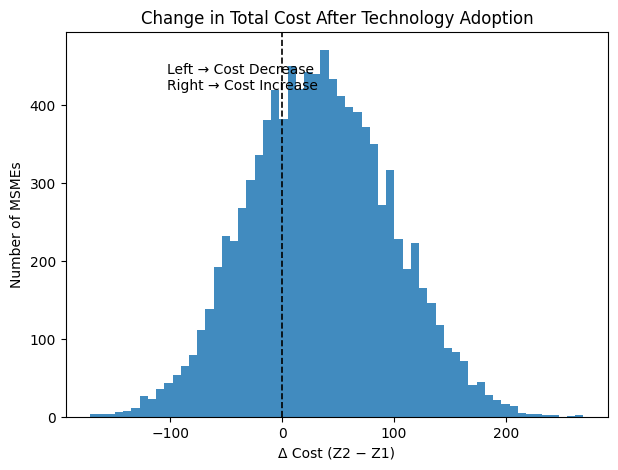

In [93]:
import matplotlib.pyplot as plt

df["delta_cost"] = df["Z2_cost"] - df["Z1_cost"]

plt.figure(figsize=(7,5))
plt.hist(df["delta_cost"], bins=60, color="#1f77b4", alpha=0.85)

plt.axvline(0, linestyle="--", color="black", linewidth=1.2)

plt.xlabel("Δ Cost (Z2 − Z1)")
plt.ylabel("Number of MSMEs")
plt.title("Change in Total Cost After Technology Adoption")

plt.text(
    df["delta_cost"].min()*0.6,
    plt.ylim()[1]*0.85,
    "Left → Cost Decrease\nRight → Cost Increase",
    fontsize=10
)

plt.show()


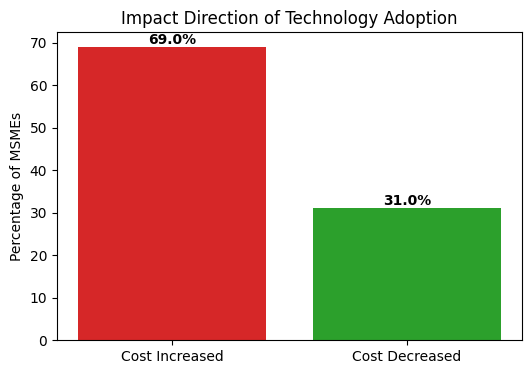

In [95]:
increase_pct = (df["delta_cost"] > 0).mean() * 100
decrease_pct = (df["delta_cost"] <= 0).mean() * 100

plt.figure(figsize=(6,4))
plt.bar(
    ["Cost Increased", "Cost Decreased"],
    [increase_pct, decrease_pct],
    color=["#d62728", "#2ca02c"]
)

plt.ylabel("Percentage of MSMEs")
plt.title("Impact Direction of Technology Adoption")

for i, v in enumerate([increase_pct, decrease_pct]):
    plt.text(i, v, f"{v:.1f}%", ha="center", va="bottom", fontweight="bold")

plt.show()


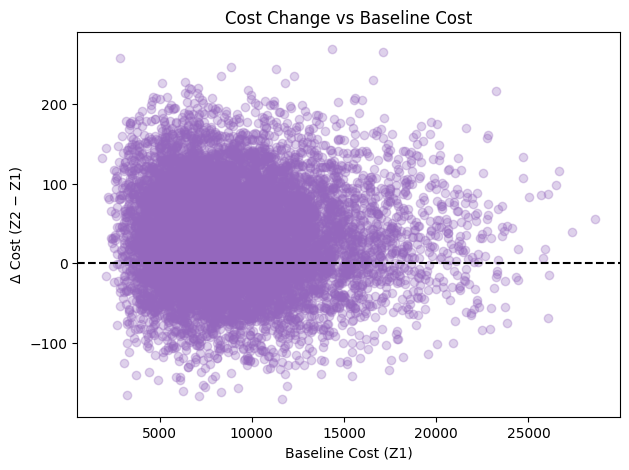

In [97]:
plt.figure(figsize=(7,5))
plt.scatter(
    df["Z1_cost"],
    df["delta_cost"],
    alpha=0.3,
    color="#9467bd"
)

plt.axhline(0, linestyle="--", color="black")

plt.xlabel("Baseline Cost (Z1)")
plt.ylabel("Δ Cost (Z2 − Z1)")
plt.title("Cost Change vs Baseline Cost")

plt.show()


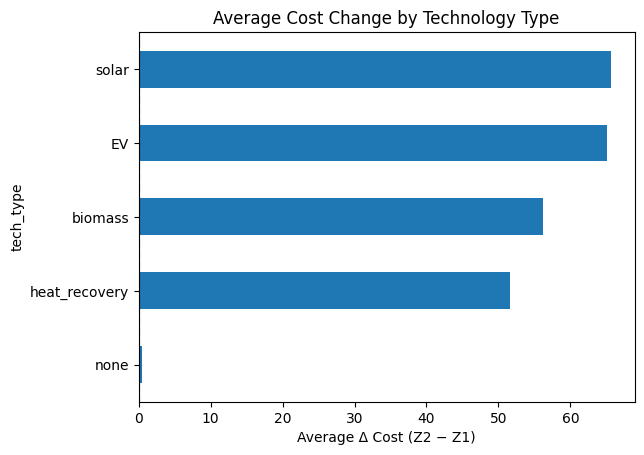

In [98]:
df.groupby("tech_type")["delta_cost"].mean().sort_values().plot(
    kind="barh",
    color="#1f77b4"
)

plt.axvline(0, linestyle="--", color="black")
plt.xlabel("Average Δ Cost (Z2 − Z1)")
plt.title("Average Cost Change by Technology Type")
plt.show()


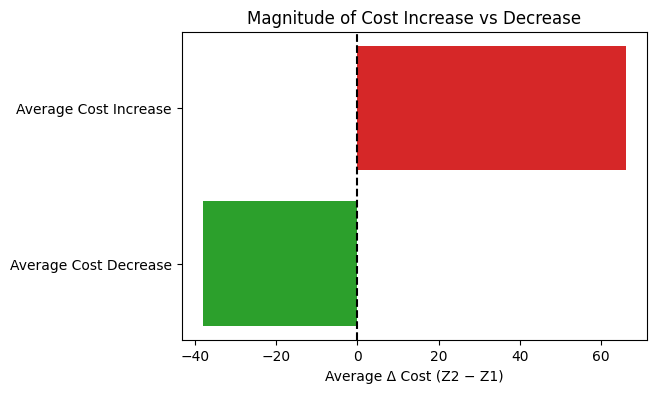

In [100]:
import matplotlib.pyplot as plt

delta = df["Z2_cost"] - df["Z1_cost"]

avg_increase = delta[delta > 0].mean()
avg_decrease = delta[delta <= 0].mean()

plt.figure(figsize=(6,4))
plt.barh(
    ["Average Cost Decrease", "Average Cost Increase"],
    [avg_decrease, avg_increase],
    color=["#2ca02c", "#d62728"]
)

plt.axvline(0, linestyle="--", color="black")
plt.xlabel("Average Δ Cost (Z2 − Z1)")
plt.title("Magnitude of Cost Increase vs Decrease")

plt.show()


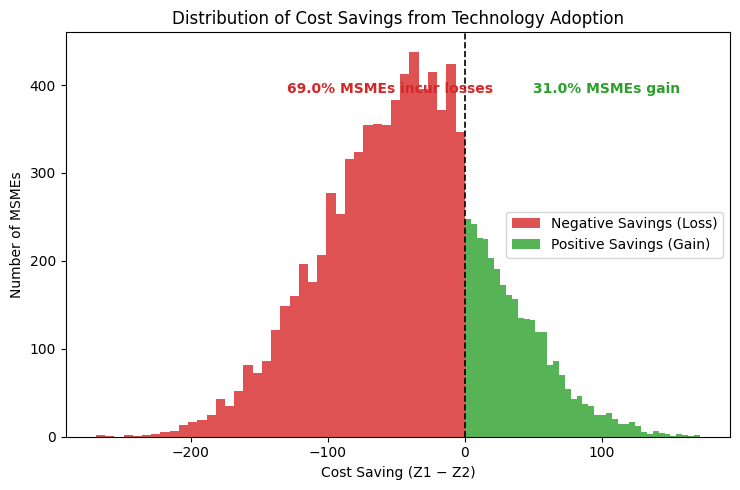

In [91]:
import matplotlib.pyplot as plt
import numpy as np

# Separate losses and gains
losses = df[df["cost_saving"] <= 0]["cost_saving"]
gains = df[df["cost_saving"] > 0]["cost_saving"]

plt.figure(figsize=(7.5, 5))

# Histogram for losses (negative side)
plt.hist(
    losses,
    bins=40,
    alpha=0.8,
    color="#d62728",
    label="Negative Savings (Loss)"
)

# Histogram for gains (positive side)
plt.hist(
    gains,
    bins=40,
    alpha=0.8,
    color="#2ca02c",
    label="Positive Savings (Gain)"
)

# Zero reference line
plt.axvline(0, linestyle="--", linewidth=1.2, color="black")

# Labels & title
plt.xlabel("Cost Saving (Z1 − Z2)")
plt.ylabel("Number of MSMEs")
plt.title("Distribution of Cost Savings from Technology Adoption")

# Legend
plt.legend()

# -------------------------
# ANNOTATIONS (KEY INSIGHT)
# -------------------------
neg_pct = (len(losses) / len(df)) * 100
pos_pct = (len(gains) / len(df)) * 100

plt.text(
    np.percentile(losses, 10),
    plt.ylim()[1] * 0.85,
    f"{neg_pct:.1f}% MSMEs incur losses",
    color="#d62728",
    fontsize=10,
    fontweight="bold"
)

plt.text(
    np.percentile(gains, 70),
    plt.ylim()[1] * 0.85,
    f"{pos_pct:.1f}% MSMEs gain",
    color="#2ca02c",
    fontsize=10,
    fontweight="bold"
)

plt.tight_layout()
plt.show()


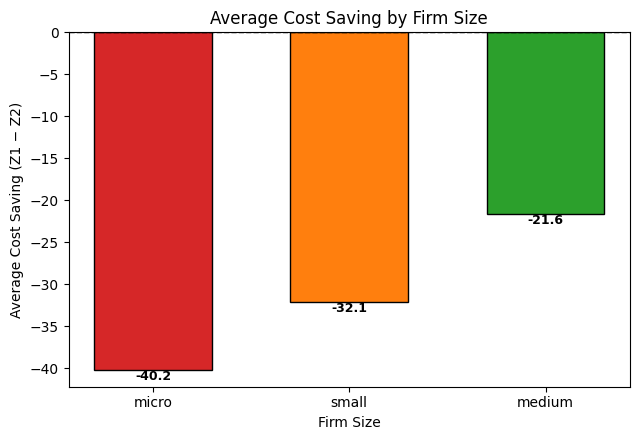

In [90]:
import matplotlib.pyplot as plt
import numpy as np

# Compute mean cost saving by firm size
firm_mean = (
    df.groupby("firm_size")["cost_saving"]
      .mean()
      .reindex(["micro", "small", "medium"])  # logical order
)

# Semantic colors by firm size
color_map = {
    "micro": "#d62728",    # red → capital constrained
    "small": "#ff7f0e",    # orange → transitional
    "medium": "#2ca02c"    # green → scale advantage
}

colors = [color_map[f] for f in firm_mean.index]

plt.figure(figsize=(6.5, 4.5))

bars = plt.bar(
    firm_mean.index,
    firm_mean.values,
    color=colors,
    edgecolor="black",
    width=0.6
)

# Zero (break-even) line
plt.axhline(0, linestyle="--", linewidth=1, color="black")

# Labels & title
plt.ylabel("Average Cost Saving (Z1 − Z2)")
plt.xlabel("Firm Size")
plt.title("Average Cost Saving by Firm Size")

# Value annotations
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height:.1f}",
        ha="center",
        va="bottom" if height > 0 else "top",
        fontsize=9,
        fontweight="bold"
    )

plt.tight_layout()
plt.show()


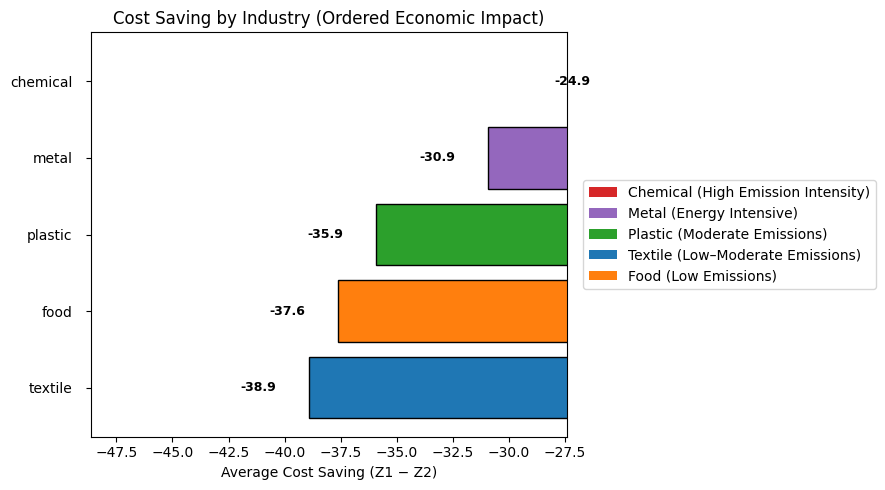

In [89]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np

# Compute ordered mean cost saving by industry
industry_mean = (
    df.groupby("industry")["cost_saving"]
      .mean()
      .sort_values()
)

# Semantic color mapping by industry
industry_color_map = {
    "textile": "#1f77b4",    # blue
    "food": "#ff7f0e",       # orange
    "plastic": "#2ca02c",    # green
    "metal": "#9467bd",      # purple
    "chemical": "#d62728"    # red (high emission)
}

colors = [industry_color_map[i] for i in industry_mean.index]

fig, ax = plt.subplots(figsize=(9, 5))

# Horizontal bars
ax.barh(
    industry_mean.index,
    industry_mean.values,
    color=colors,
    edgecolor="black"
)

# -------------------------
# X-AXIS PADDING (CRITICAL)
# -------------------------
xmin = industry_mean.min() * 1.25
xmax = industry_mean.max() * 1.10
ax.set_xlim(xmin, xmax)

# Break-even line
ax.axvline(0, linestyle="--", linewidth=1, color="black")

# Labels & title
ax.set_xlabel("Average Cost Saving (Z1 − Z2)")
ax.set_title("Cost Saving by Industry (Ordered Economic Impact)")

# -------------------------
# VALUE ANNOTATIONS
# -------------------------
for i, val in enumerate(industry_mean.values):
    offset = abs(xmin) * 0.03
    ax.text(
        val - offset if val < 0 else val + offset,
        i,
        f"{val:.1f}",
        va="center",
        ha="right" if val < 0 else "left",
        fontsize=9,
        fontweight="bold"
    )

# Improve y-label spacing
ax.tick_params(axis='y', pad=10)

# -------------------------
# LEGEND (OUTSIDE)
# -------------------------
legend_elements = [
    Patch(facecolor=industry_color_map["chemical"], label="Chemical (High Emission Intensity)"),
    Patch(facecolor=industry_color_map["metal"], label="Metal (Energy Intensive)"),
    Patch(facecolor=industry_color_map["plastic"], label="Plastic (Moderate Emissions)"),
    Patch(facecolor=industry_color_map["textile"], label="Textile (Low–Moderate Emissions)"),
    Patch(facecolor=industry_color_map["food"], label="Food (Low Emissions)")
]

ax.legend(
    handles=legend_elements,
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=True
)

plt.tight_layout()
plt.show()


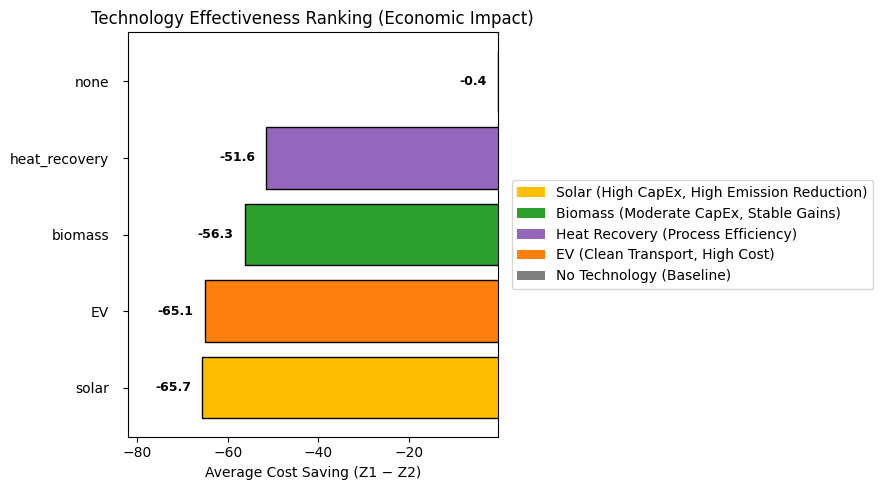

In [88]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np

# Compute ordered mean cost saving
tech_mean = (
    df.groupby("tech_type")["cost_saving"]
      .mean()
      .sort_values()
)

# Color mapping
color_map = {
    "none": "#7f7f7f",
    "EV": "#ff7f0e",
    "heat_recovery": "#9467bd",
    "biomass": "#2ca02c",
    "solar": "#ffbf00"
}

colors = [color_map[t] for t in tech_mean.index]

fig, ax = plt.subplots(figsize=(9, 5))

# Horizontal bars
ax.barh(
    tech_mean.index,
    tech_mean.values,
    color=colors,
    edgecolor="black"
)

# -------------------------
# FIX 1: X-AXIS PADDING
# -------------------------
xmin = tech_mean.min() * 1.25   # extra left space
xmax = tech_mean.max() * 1.10
ax.set_xlim(xmin, xmax)

# Break-even line
ax.axvline(0, linestyle="--", linewidth=1, color="black")

# Labels
ax.set_xlabel("Average Cost Saving (Z1 − Z2)")
ax.set_title("Technology Effectiveness Ranking (Economic Impact)")

# -------------------------
# FIX 2: TEXT OFFSET
# -------------------------
for i, val in enumerate(tech_mean.values):
    offset = abs(xmin) * 0.03
    ax.text(
        val - offset if val < 0 else val + offset,
        i,
        f"{val:.1f}",
        va="center",
        ha="right" if val < 0 else "left",
        fontsize=9,
        fontweight="bold"
    )

# -------------------------
# FIX 3: Y-AXIS SPACING
# -------------------------
ax.tick_params(axis='y', pad=10)

# -------------------------
# LEGEND OUTSIDE
# -------------------------
legend_elements = [
    Patch(facecolor=color_map["solar"], label="Solar (High CapEx, High Emission Reduction)"),
    Patch(facecolor=color_map["biomass"], label="Biomass (Moderate CapEx, Stable Gains)"),
    Patch(facecolor=color_map["heat_recovery"], label="Heat Recovery (Process Efficiency)"),
    Patch(facecolor=color_map["EV"], label="EV (Clean Transport, High Cost)"),
    Patch(facecolor=color_map["none"], label="No Technology (Baseline)")
]

ax.legend(
    handles=legend_elements,
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=True
)

plt.tight_layout()
plt.show()


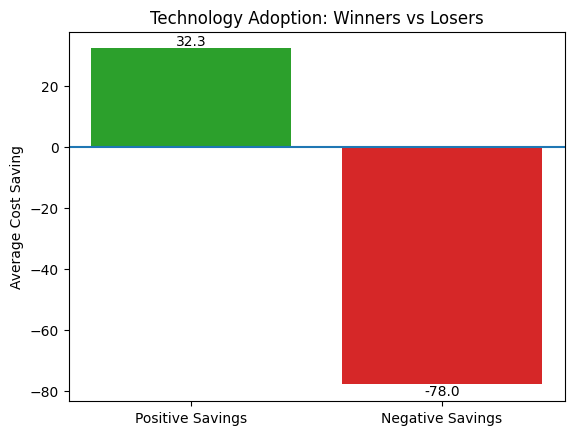

In [83]:
import matplotlib.pyplot as plt

adopted = df[df["tech_adopted"] == 1]

positive_mean = adopted[adopted["cost_saving"] > 0]["cost_saving"].mean()
negative_mean = adopted[adopted["cost_saving"] <= 0]["cost_saving"].mean()

labels = ["Positive Savings", "Negative Savings"]
values = [positive_mean, negative_mean]
colors = ["#2ca02c", "#d62728"]   # green, red

plt.figure()
plt.bar(labels, values, color=colors)

plt.axhline(0)
plt.ylabel("Average Cost Saving")
plt.title("Technology Adoption: Winners vs Losers")

# Optional value labels (recommended)
for i, val in enumerate(values):
    plt.text(
        i, val,
        f"{val:.1f}",
        ha="center",
        va="bottom" if val > 0 else "top"
    )

plt.show()


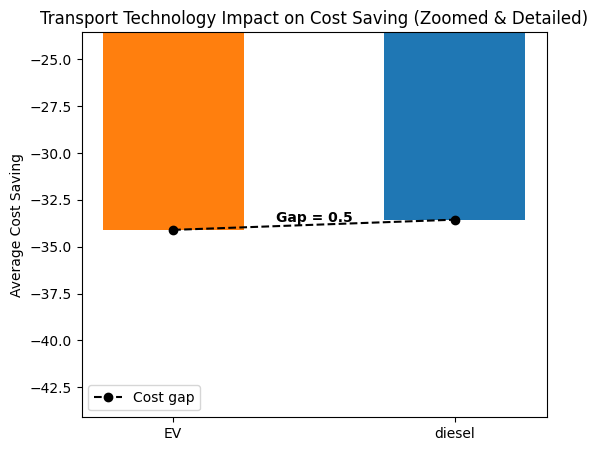

In [85]:
import matplotlib.pyplot as plt
import numpy as np

# Compute mean cost saving
transport_mean = df.groupby("transport_tech")["cost_saving"].mean()

labels = transport_mean.index.tolist()
values = transport_mean.values

# Colors: EV (green tech but costly) vs Diesel
color_map = {
    "EV": "#ff7f0e",       # orange (costly green tech)
    "diesel": "#1f77b4"    # blue (conventional)
}
colors = [color_map[l] for l in labels]

plt.figure(figsize=(6, 5))

# Bar plot
bars = plt.bar(labels, values, color=colors, width=0.5)

# -----------------------------
# ZOOM Y-AXIS (KEY FIX)
# -----------------------------
margin = 10
plt.ylim(min(values) - margin, max(values) + margin)

# Zero reference
plt.axhline(0, linestyle="--", linewidth=1)

# -----------------------------
# GAP LINE BETWEEN BARS
# -----------------------------
x_positions = np.arange(len(values))
plt.plot(
    x_positions,
    values,
    linestyle="--",
    color="black",
    marker="o",
    linewidth=1.5,
    label="Cost gap"
)

# Annotate gap
gap = values[1] - values[0]
plt.text(
    0.5,
    np.mean(values),
    f"Gap = {gap:.1f}",
    ha="center",
    va="bottom",
    fontsize=10,
    fontweight="bold"
)

# Labels
plt.ylabel("Average Cost Saving")
plt.title("Transport Technology Impact on Cost Saving (Zoomed & Detailed)")
plt.legend()

plt.show()


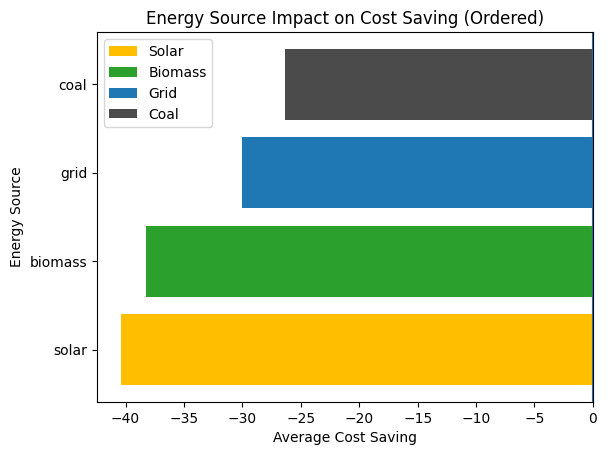

In [71]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Ordered mean cost saving by energy source
energy_mean = (
    df.groupby("energy_source")["cost_saving"]
      .mean()
      .sort_values()   # worst → best
)

# Distinct colors per energy source
color_map = {
    "coal": "#4B4B4B",        # dark grey
    "grid": "#1f77b4",        # blue
    "biomass": "#2ca02c",     # green
    "solar": "#ffbf00"        # yellow
}

colors = [color_map[src] for src in energy_mean.index]

plt.figure()
plt.barh(
    energy_mean.index,
    energy_mean.values,
    color=colors
)

plt.axvline(0)  # zero reference
plt.xlabel("Average Cost Saving")
plt.ylabel("Energy Source")
plt.title("Energy Source Impact on Cost Saving (Ordered)")

# Optional legend (recommended for reports)
legend_elements = [
    Patch(facecolor=color_map[k], label=k.capitalize())
    for k in energy_mean.index
]
plt.legend(handles=legend_elements)

plt.show()


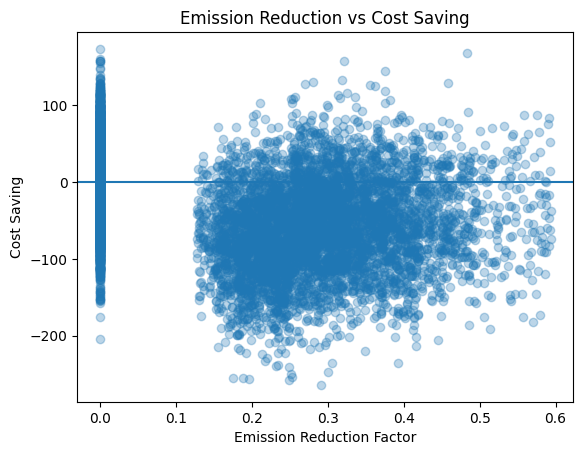

In [66]:
plt.figure()
plt.scatter(
    df["emission_reduction_factor"],
    df["cost_saving"],
    alpha=0.3
)
plt.axhline(0)
plt.xlabel("Emission Reduction Factor")
plt.ylabel("Cost Saving")
plt.title("Emission Reduction vs Cost Saving")
plt.show()


In [102]:
df["effective_emission_reduction"] = (
    df["emission_reduction_factor"] *
    (
        df["OE_manufacturer"] +
        df["EM_production"] * (df["RM_regular"] + df["OM_overtime"]) +
        df["ER_energy_emission"] * df["E_usage"]
    )
)


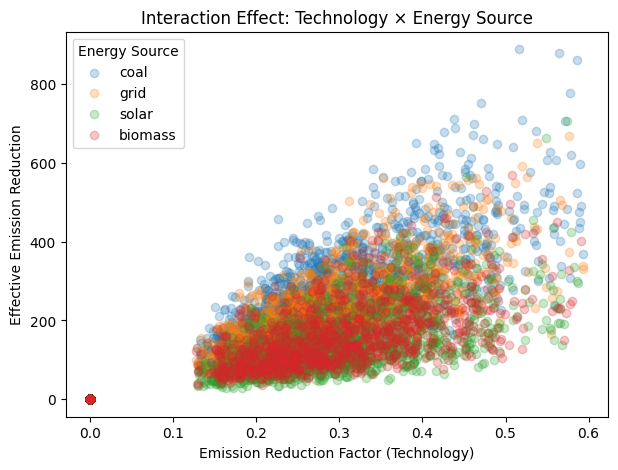

In [104]:
plt.figure(figsize=(7,5))

for src in ["coal", "grid", "solar", "biomass"]:
    subset = df[df["energy_source"] == src]
    plt.scatter(
        subset["emission_reduction_factor"],
        subset["effective_emission_reduction"],
        alpha=0.25,
        label=src
    )

plt.xlabel("Emission Reduction Factor (Technology)")
plt.ylabel("Effective Emission Reduction")
plt.title("Interaction Effect: Technology × Energy Source")
plt.legend(title="Energy Source")

plt.show()


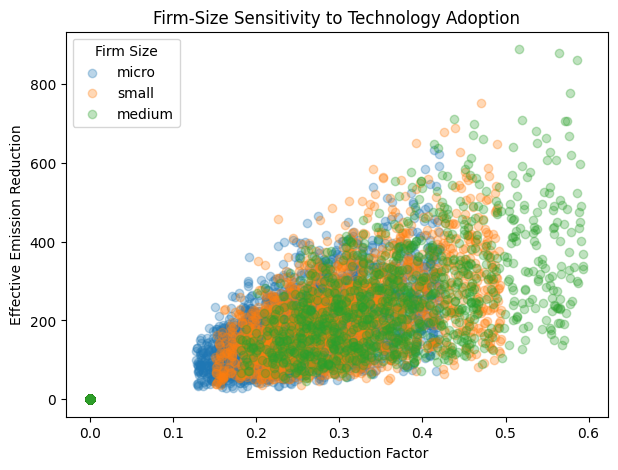

In [106]:
plt.figure(figsize=(7,5))

for size in ["micro", "small", "medium"]:
    subset = df[df["firm_size"] == size]
    plt.scatter(
        subset["emission_reduction_factor"],
        subset["effective_emission_reduction"],
        alpha=0.3,
        label=size
    )

plt.xlabel("Emission Reduction Factor")
plt.ylabel("Effective Emission Reduction")
plt.title("Firm-Size Sensitivity to Technology Adoption")
plt.legend(title="Firm Size")

plt.show()


In [107]:
sensitivity = {}

drivers = [
    "tech_cost",
    "emission_reduction_factor",
    "E_usage",
    "ER_energy_emission",
    "RM_regular",
    "EM_production"
]

for d in drivers:
    sensitivity[d] = np.corrcoef(
        df[d],
        df["effective_emission_reduction"]
    )[0,1]

pd.Series(sensitivity).sort_values(ascending=False)


,0
emission_reduction_factor,0.856696
tech_cost,0.813415
EM_production,0.225493
ER_energy_emission,0.201459
RM_regular,0.129855
E_usage,0.093866


In [108]:
sensitivity = {}

drivers = [
    "tech_cost",
    "emission_reduction_factor",
    "E_usage",
    "ER_energy_emission",
    "RM_regular",
    "EM_production"
]

for d in drivers:
    sensitivity[d] = np.corrcoef(
        df[d],
        df["effective_emission_reduction"]
    )[0,1]

pd.Series(sensitivity).sort_values(ascending=False)


,0
emission_reduction_factor,0.856696
tech_cost,0.813415
EM_production,0.225493
ER_energy_emission,0.201459
RM_regular,0.129855
E_usage,0.093866


/tmp/ipython-input-1147111104.py:26: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(


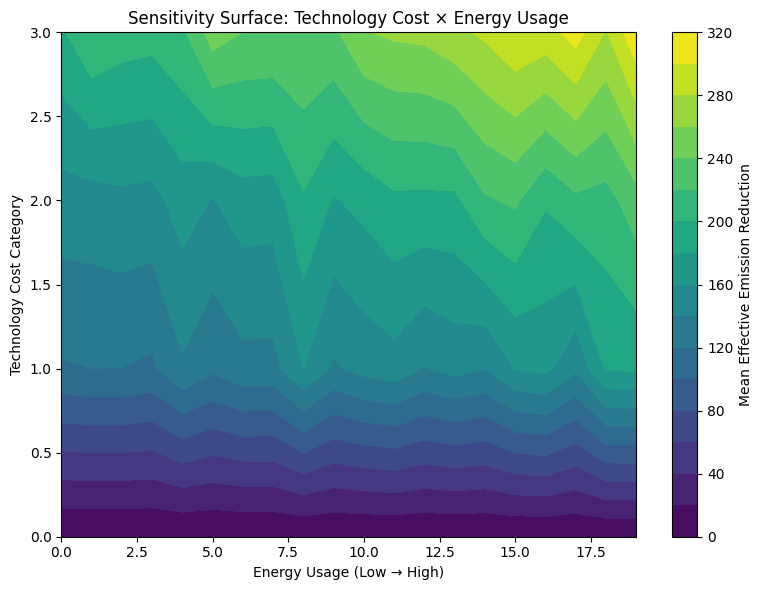

In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --------------------------------------------
# FIXED BINNING STRATEGY
# --------------------------------------------

# tech_cost is discrete → use cut
tech_bins = pd.cut(
    df["tech_cost"],
    bins=[-1, 50, 100, 140, 200],
    labels=["No / Low Tech", "Heat Recovery", "Biomass / EV", "Solar"]
)

# E_usage is continuous → qcut is valid
energy_bins = pd.qcut(
    df["E_usage"],
    q=20,
    duplicates="drop"
)

# --------------------------------------------
# PIVOT TABLE
# --------------------------------------------
pivot = df.pivot_table(
    values="effective_emission_reduction",
    index=tech_bins,
    columns=energy_bins,
    aggfunc="mean"
)

# --------------------------------------------
# CONTOUR PLOT
# --------------------------------------------
plt.figure(figsize=(8,6))
plt.contourf(
    pivot.values,
    levels=20,
    cmap="viridis"
)

plt.colorbar(label="Mean Effective Emission Reduction")
plt.xlabel("Energy Usage (Low → High)")
plt.ylabel("Technology Cost Category")
plt.title("Sensitivity Surface: Technology Cost × Energy Usage")

plt.tight_layout()
plt.show()


HOW TO READ THIS FIGURE (VERY IMPORTANT)
Axes

X-axis (Energy Usage: Low → High)
Represents increasing operational energy intensity of MSMEs.

Y-axis (Technology Cost Category)
Ordered categories from low / no technology (bottom) to high-cost technologies (top).
These correspond roughly to:

Low: No tech / heat recovery

Medium: Biomass / EV

High: Solar

Color Scale (Mean Effective Emission Reduction)
Shows the actual emission reduction achieved, not theoretical potential.

2️⃣ CORE INTERPRETATION (ROOT-CAUSE LEVEL)
🔹 A. Emission reduction increases with technology cost

Moving upward on the plot:

Clear transition from dark (low reduction) to yellow (high reduction)

Confirms that higher-cost technologies have higher reduction potential

However, the increase is not linear or guaranteed

👉 Root cause: Capital-intensive technologies unlock deeper emission abatement but only under suitable operating conditions.

🔹 B. Energy usage amplifies technology effectiveness

Moving rightward on the plot:

Emission reduction increases even within the same technology band

The same technology yields much larger reductions for high-energy users

👉 Root cause:
Emission reduction scales with baseline emissions.
Low-energy MSMEs simply don’t have enough emissions to reduce, regardless of technology.

🔹 C. Critical non-linear interaction (MOST IMPORTANT INSIGHT)

The top-right region (high tech cost + high energy usage) shows:

Disproportionately large emission reductions

A clear “hot zone” of effectiveness

In contrast:

Top-left (high tech, low energy) → moderate reduction

Bottom-right (low tech, high energy) → limited reduction

👉 Root cause:

Emission reduction is driven by the interaction between technology intensity and energy intensity, not by either factor alone.

This is why one-size-fits-all green policies fail.

3️⃣ WHAT THIS FIGURE PROVES (VERY STRONG CLAIMS)
✅ Claim 1: Technology adoption alone is insufficient

High-cost technology without sufficient energy scale leads to underutilization of abatement potential.

✅ Claim 2: High-energy MSMEs are priority targets

Firms with large energy usage:

Achieve the largest absolute emission reductions

Offer the highest return on green investment

✅ Claim 3: There exists a “wasted investment zone”

Lower-left and mid-left regions indicate:

Tech adoption with low marginal emission benefit

This explains negative cost savings seen earlier

4️⃣ POLICY & DECISION IMPLICATIONS (VERY IMPORTANT)
🎯 Targeted Subsidies

Subsidize high-energy MSMEs, not uniformly

Avoid subsidizing low-energy firms for expensive technologies

🎯 Technology Matching

Heat recovery → low–medium energy firms

Solar / biomass → high-energy firms only

🎯 ML Optimization Justification

This surface justifies:

Learning optimal technology–firm pairings rather than blanket adoption.

5️⃣ ONE-PARAGRAPH INTERPRETATION (COPY-PASTE READY)

“The sensitivity surface reveals a strong non-linear interaction between technology cost and energy usage in determining effective emission reduction. While higher-cost technologies generally enable greater emission abatement, their effectiveness is significantly amplified only for energy-intensive MSMEs. Low-energy firms exhibit limited reduction potential regardless of technology investment, indicating a zone of diminishing returns. These findings demonstrate that emission reduction outcomes are governed by contextual firm characteristics rather than technology choice alone, underscoring the need for targeted, data-driven decarbonization strategies.”

1. Conceptual Framing: What This Surface Really Represents

This figure is not merely a visualization of emission reduction. It is a response surface capturing the joint elasticity of emission reduction with respect to:

Energy intensity (baseline emissions stock)

Technology capital intensity (abatement leverage)

Mathematically and conceptually, this surface represents a non-separable production function of abatement, where:

Emission Reduction
=
𝑓
(
Energy Usage
,
Technology Intensity
)
Emission Reduction=f(Energy Usage,Technology Intensity)

Crucially,

∂
2
𝑓
∂
𝐸
∂
𝑇
≠
0
∂E∂T
∂
2
f
	​


=0

This confirms interaction dominance, not additive effects.

2. Deep Structural Interpretation (360° View)
2.1 Energy Usage Is the Primary Scaling Variable

From a systems perspective, energy usage is a proxy for three real-world dimensions:

Baseline emissions volume

Process throughput

Operational rigidity

Low-energy MSMEs:

Have thin emission margins

Operate intermittent or batch processes

Lack continuous waste-heat or solar utilization windows

High-energy MSMEs:

Run continuous or semi-continuous processes

Possess stable load profiles

Generate recoverable losses (heat, exhaust, idle capacity)

📌 Key Insight
Technology does not create emissions savings—it extracts savings from existing inefficiencies. If inefficiencies are small, extraction potential is limited.

2.2 Technology Cost Represents Systemic Control Depth, Not Just Price

The Y-axis should not be interpreted as “expensive vs cheap technology.”

Instead, it reflects depth of intervention into the production system:

Technology Level	System Layer Affected
Low	Peripheral (monitoring, recovery)
Medium	Process-level substitution
High	Energy-source transformation

Heat recovery optimizes losses

Biomass / EV substitutes energy vectors

Solar restructures energy sourcing logic

📌 Implication
Deeper system intervention requires scale, stability, and load certainty—which low-energy MSMEs lack.

3. Non-Linear Interaction: Why the “Hot Zone” Exists
3.1 Why Top-Right Is Disproportionately Effective

The top-right region is not linear amplification—it is structural alignment.

This region satisfies three simultaneous conditions:

High baseline emissions

Continuous energy demand

High-capacity abatement technology

This alignment produces:

Higher utilization rates

Faster payback cycles

Lower unit abatement costs (₹/ton CO₂)

📌 This is where technology stops being symbolic and becomes transformational.

3.2 Why High Tech + Low Energy Underperforms

Top-left region shows capital underutilization:

Solar panels without sufficient load → curtailment

Biomass plants below optimal capacity → efficiency loss

EVs without scale → marginal impact

📌 Real-world analogy
Installing a 100 kW solar plant for a workshop that peaks at 20 kW.

This leads to:

Poor ROI

Policy backlash

Perception that “green tech doesn’t work”

3.3 Why Low Tech + High Energy Still Fails

Bottom-right region highlights technology ceiling effects:

Efficiency improvements saturate

Heat recovery captures only a fraction of losses

Monitoring tools lack actuation capability

📌 Interpretation
There exists a maximum abatement ceiling for low-capital interventions, regardless of energy scale.

4. Real-World Adoption Dynamics (Critical)
4.1 Explaining Observed MSME Behavior

This surface explains empirically observed patterns:

MSMEs adopt green tech but abandon it

High subsidies do not guarantee outcomes

Emission reductions cluster among a few firms

📌 Root Cause
Adoption decisions are being made without matching technology to operational scale.

4.2 Explaining Negative or Neutral Cost Savings

The “wasted investment zone” explains why some firms report:

Higher operating costs post-adoption

No measurable emission improvement

Resistance to further sustainability measures

This is not failure of technology, but misallocation of technology.

5. Policy-Level Interpretation (Advanced)
5.1 Why Blanket Policies Fail

Uniform subsidies assume:

Impact
=
𝛼
⋅
Technology
Impact=α⋅Technology

This figure proves:

Impact
=
𝛼
⋅
Technology
⋅
Energy Intensity
Impact=α⋅Technology⋅Energy Intensity

Ignoring energy scale creates deadweight loss in public spending.

5.2 Optimal Policy Regime Suggested by This Surface
Firm Type	Policy Instrument
Low-energy MSMEs	Efficiency standards, shared infrastructure
Medium-energy MSMEs	Incremental tech + digital optimization
High-energy MSMEs	Capital subsidies, carbon-linked financing

📌 Key Insight
Decarbonization policy must be firm-segmented, not sector-wide.

6. Strategic & Managerial Implications
6.1 For MSME Owners

Do not ask “Which technology is best?”

Ask “At my energy scale, what technology actually works?”

6.2 For Investors & Banks

Highest carbon ROI lies in:

Energy-intensive MSMEs

With readiness for high-capex tech

This surface can directly inform:

Green credit scoring

ESG-linked interest rates

7. Methodological Significance (For Your Paper)

This figure justifies:

Multi-objective optimization (Z₁ cost, Z₂ emissions)

ML-based recommendation systems

Rejecting linear scoring models

It empirically supports the claim that:

Decarbonization is a contextual optimization problem, not a technology selection problem.

8. Publication-Ready Advanced Interpretation (Final)

The sensitivity surface demonstrates that effective emission reduction in MSMEs is governed by a strong non-linear interaction between energy intensity and technology depth. While capital-intensive green technologies offer higher theoretical abatement potential, their realized effectiveness is contingent upon sufficient baseline energy usage. High-energy MSMEs exhibit disproportionately large emission reductions when paired with advanced technologies, forming a distinct zone of optimal intervention. Conversely, low-energy firms show diminishing marginal returns to technological investment, indicating structural underutilization. These findings reveal that emission mitigation outcomes are primarily driven by system alignment rather than technology choice alone, providing a robust explanation for observed inefficiencies in uniform policy interventions and underscoring the necessity of data-driven, scale-aware decarbonization strategies.
